# LLM Interface
The `effectful.handlers.llm` module provides a simplified LLM interface that uses algebraic effects for modularity. The module interface consists of:

- A decorator `Template.define` which creates a prompt template from a callable. A template is an LLM-implemented function whose behavior is specified by a template string. When a template is called, an LLM is invoked to produce the specified behavior.
- A decorator `Tool.define` which exposes Python callables as tools that templates can call. Tool signatures and docstrings define the schema passed to the model.
- Structured output handling via `Encodable` (used internally by templates and tool calls) to serialize/deserialize Python types.
- LLM providers such as `LiteLLMProvider`, and reliability helpers like `RetryLLMHandler` and `ReplayLiteLLMProvider`, which can be composed with `handler(...)` to control execution.

In [18]:
import base64
import dataclasses
import functools
import inspect
import io
from collections.abc import Callable
from typing import Literal

import litellm
import pydantic
from IPython.display import HTML, display
from litellm.caching.caching import Cache
from PIL import Image
from pydantic import field_validator
from pydantic_core import PydanticCustomError

from effectful.handlers.llm import Template, Tool
from effectful.handlers.llm.completions import (
    LiteLLMProvider,
    RetryLLMHandler,
)
from effectful.handlers.llm.evaluation import DoctestHandler, UnsafeEvalProvider
from effectful.ops.semantics import NotHandled, handler

provider = LiteLLMProvider()

ImportError: cannot import name 'DoctestHandler' from 'effectful.handlers.llm.evaluation' (/Users/nguyendat/Marc/effectful/effectful/handlers/llm/evaluation.py)

In the following sections, we walk through each of the mentioned components.

## Prompt Templates

This template function writes (bad) poetry on a given theme. While difficult to implement in Python, an LLM can provide a reasonable implementation.

In [2]:
@Template.define
def limerick(theme: str) -> str:
    """Write a limerick on the theme of {theme}. Do not use any tools."""
    raise NotHandled

If we call the template with a provider interpretation installed, we get reasonable behavior. The LLM is nondeterministic by default, so calling the template twice with the same arguments gives us different results.

Templates are regular callables, so can be converted to operations with `defop` if we want to override the LLM implementation in some cases.

In [3]:
with handler(provider):
    print(limerick("fish"))
    print("-" * 40)
    print(limerick("fish"))

In the sea where the silver fish play,
A salmon once swam by the bay.
With a splash and a swirl,
Past the shells it would twirl,
And vanish at the end of the day.
----------------------------------------
In the ocean, where fish freely roam,
A small school called a coral reef home.
With fins all aglow,
They dart to and fro,
Dancing waves as sea breezes comb.


If we want deterministic behavior, we can cache the template call. We can either cache it with the default `@functools.cache` or use LiteLLM's built-in cache by setting a cache backend and passing `caching=True` to the provider:

In [4]:
@functools.cache
@Template.define
def haiku(theme: str) -> str:
    """Write a haiku on the theme of {theme}. Do not use any tools."""
    raise NotHandled


@Template.define
def haiku_no_cache(theme: str) -> str:
    """Write a haiku on the theme of {theme}. Do not use any tools."""
    raise NotHandled


print()
with handler(provider):
    print(haiku("fish"))
    print("-" * 40)
    print(haiku("fish"))

print()
# Enable LiteLLM caching by setting a cache backend and enabling caching.
litellm.cache = Cache()
provider_cached = LiteLLMProvider(caching=True)
try:
    with handler(provider_cached):
        print(haiku_no_cache("fish2"))
        print("-" * 40)
        print(haiku_no_cache("fish2"))
finally:
    litellm.cache = None

print()
with handler(provider):
    print(haiku_no_cache("fish3"))
    print("-" * 40)
    print(haiku_no_cache("fish3"))


Silent water glides,
Scales shimmering through currents—
Nature's art in waves.
----------------------------------------
Silent water glides,
Scales shimmering through currents—
Nature's art in waves.



/Users/nguyendat/Marc/effectful/.venv/lib/python3.12/site-packages/pydantic/main.py:528: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 10 fields but got 6: Expected `Message` - serialized value may not be as expected [field_name='message', input_value=Message(content='{"value"...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [field_name='choices', input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_json(


Silent waters gleam,  
Fish dart in a moonlit stream,  
Nature's quiet dream.
----------------------------------------
Silent waters dance,  
Scales shimmer in fleeting light,  
Fish glide through soft dreams.

Fish swim through blue waves,  
Their scales gleam like silver jewels,  
Silent in the deep.
----------------------------------------
Silent waters flow,
Fish dart beneath gentle waves—
Nature's dance below.


## Converting LLM Results to Python Objects

Type conversion is handled by `decode`. By default, primitive types are converted. `DecodeError` is raised if a response cannot be converted.

In [5]:
@Template.define
def primes(first_digit: int) -> int:
    """Give a prime number with {first_digit} as the first digit. Do not use any tools."""
    raise NotHandled


with handler(provider):
    assert type(primes(6)) is int

More complex types can be converted by providing handlers for `decode`. Callable synthesis is supported via `Encodable` and the evaluation providers in `effectful.handlers.llm.evaluation` (`UnsafeEvalProvider` or `RestrictedEvalProvider`), which enable parsing/compiling/executing synthesized code.

In [ ]:
@Template.define
def count_char(char: str) -> Callable[[str], int]:
    """Write a function named count_char which takes a string and counts the occurrances of '{char}'. Do not use any tools.

    Examples:
        >>> count_char("banana")
        3
        >>> count_char("cherry")
        0
    """
    raise NotHandled


# Use UnsafeEvalProvider for simple examples; RestrictedEvalProvider may need extra globals.
with handler(provider), handler(UnsafeEvalProvider()), handler(DoctestHandler()):
    count_a = count_char("a")
    assert callable(count_a)
    assert count_a("banana") == 3
    assert count_a("cherry") == 0
    # Print the source code of the generated function
    print(inspect.getsource(count_a))

def count_char_a(text: str) -> int:
    """
    Counts the occurrences of 'a' in the given string.

    Args:
        text (str): The string to search within.

    Returns:
        int: The count of 'a' characters in the string.

    Examples:
        >>> count_char_a('banana')
        3
        >>> count_char_a('apple')
        1
        >>> count_char_a('cherry')
        0
    """
    count = 0
    for char in text:
        if char == 'a':
            count += 1
    return count



### Doctest Feedback

Write doctests in the template docstring for callable synthesis. The docstring is formatted with the call arguments, and the doctests are executed during decoding.

In [7]:
@Template.define
def count_char_with_doctest(char: str) -> Callable[[str], int]:
    """Write a function named count_char that counts the occurrances of '{char}'.
    Do not use any tools.
    """
    raise NotHandled


with handler(provider), handler(UnsafeEvalProvider()), handler(DoctestHandler()):
    count_a = count_char_with_doctest("a")
    assert count_a("banana") == 3

ResultDecodingError: Error decoding response: mypy type check failed:
<string>:170: [1m[31merror:[m Name [m[1m"count_char"[m already defined on line 159  [m[33m[no-redef][m

import collections
import collections.abc
import IPython
import IPython.core
import IPython.core.alias
import IPython.core.application
import IPython.core.async_helpers
import IPython.core.autocall
import IPython.core.builtin_trap
import IPython.core.compilerop
import IPython.core.completer
import IPython.core.completerlib
import IPython.core.crashhandler
import IPython.core.debugger
import IPython.core.debugger_backport
import IPython.core.display
import IPython.core.display_functions
import IPython.core.display_trap
import IPython.core.displayhook
import IPython.core.displaypub
import IPython.core.doctb
import IPython.core.error
import IPython.core.events
import IPython.core.extensions
import IPython.core.formatters
import IPython.core.getipython
import IPython.core.guarded_eval
import IPython.core.history
import IPython.core.hooks
import IPython.core.inputtransformer2
import IPython.core.interactiveshell
import IPython.core.latex_symbols
import IPython.core.logger
import IPython.core.macro
import IPython.core.magic
import IPython.core.magic_arguments
import IPython.core.magics
import IPython.core.magics.ast_mod
import IPython.core.magics.auto
import IPython.core.magics.basic
import IPython.core.magics.code
import IPython.core.magics.config
import IPython.core.magics.display
import IPython.core.magics.execution
import IPython.core.magics.extension
import IPython.core.magics.history
import IPython.core.magics.logging
import IPython.core.magics.namespace
import IPython.core.magics.osm
import IPython.core.magics.packaging
import IPython.core.magics.pylab
import IPython.core.magics.script
import IPython.core.oinspect
import IPython.core.page
import IPython.core.payload
import IPython.core.prefilter
import IPython.core.profiledir
import IPython.core.release
import IPython.core.shellapp
import IPython.core.splitinput
import IPython.core.tbtools
import IPython.core.tips
import IPython.core.ultratb
import IPython.core.usage
import IPython.display
import IPython.extensions
import IPython.extensions.storemagic
import IPython.external
import IPython.external.pickleshare
import IPython.lib
import IPython.lib.clipboard
import IPython.lib.display
import IPython.lib.pretty
import IPython.paths
import IPython.terminal
import IPython.terminal.debugger
import IPython.terminal.embed
import IPython.terminal.interactiveshell
import IPython.terminal.ipapp
import IPython.terminal.magics
import IPython.terminal.prompts
import IPython.terminal.pt_inputhooks
import IPython.terminal.ptutils
import IPython.terminal.shortcuts
import IPython.terminal.shortcuts.auto_match
import IPython.terminal.shortcuts.auto_suggest
import IPython.terminal.shortcuts.filters
import IPython.testing
import IPython.testing.skipdoctest
import IPython.utils
import IPython.utils.PyColorize
import IPython.utils._process_common
import IPython.utils._process_posix
import IPython.utils._sysinfo
import IPython.utils.capture
import IPython.utils.contexts
import IPython.utils.data
import IPython.utils.decorators
import IPython.utils.dir2
import IPython.utils.docs
import IPython.utils.encoding
import IPython.utils.frame
import IPython.utils.generics
import IPython.utils.importstring
import IPython.utils.io
import IPython.utils.ipstruct
import IPython.utils.module_paths
import IPython.utils.openpy
import IPython.utils.path
import IPython.utils.process
import IPython.utils.py3compat
import IPython.utils.sentinel
import IPython.utils.strdispatch
import IPython.utils.sysinfo
import IPython.utils.syspathcontext
import IPython.utils.terminal
import IPython.utils.text
import IPython.utils.timing
import IPython.utils.tokenutil
import IPython.utils.wildcard
import collections
import collections.abc
import effectful
import effectful.handlers
import effectful.handlers.llm
import effectful.handlers.llm.completions
import effectful.handlers.llm.encoding
import effectful.handlers.llm.evaluation
import effectful.handlers.llm.template
import effectful.internals
import effectful.internals.runtime
import effectful.internals.unification
import effectful.ops
import effectful.ops.semantics
import effectful.ops.syntax
import effectful.ops.types
import pathlib
In: collections.abc.MutableSequence[str]
Out: dict
_: str
__: str
___: str
__vsc_ipynb_file__: str
_dh: collections.abc.MutableSequence[pathlib.PosixPath]
_i: str
_i1: str
_i2: str
_i3: str
_i4: str
_i5: str
_i6: str
_i7: str
_ih: collections.abc.MutableSequence[str]
_ii: str
_iii: str
_oh: dict
char: str
count_a: collections.abc.Callable[[str], int]
count_char: effectful.ops.types.Operation[[str], collections.abc.Callable[[str], int]]
count_char_with_doctest: effectful.ops.types.Operation[[str], collections.abc.Callable[[str], int]]
exit: IPython.core.autocall.ZMQExitAutocall
haiku: collections.abc.Callable[[str], str]
haiku_no_cache: effectful.ops.types.Operation[[str], str]
limerick: effectful.ops.types.Operation[[str], str]
primes: effectful.ops.types.Operation[[int], int]
provider: effectful.ops.types.Interpretation
provider_cached: effectful.ops.types.Interpretation
quit: IPython.core.autocall.ZMQExitAutocall

def count_char(s: str) -> int:
    """
    Count the occurrences of the character 'a' in the given string.

    Args:
    s (str): The string in which to count occurrences of 'a'.

    Returns:
    int: The number of times 'a' appears in the string.

    Examples:
    >>> count_char('banana')
    3
    >>> count_char('apple')
    1
    >>> count_char('cherry')
    0
    """
    return s.count('a')
_synthesized_check: collections.abc.Callable[[str], int] = count_char. Please provide a valid response and try again.

## Tool Calling

`Operation`s defined in the lexical scope of a `Template` are automatically available for the LLM to call as tools. The description of these operations is inferred from their type annotations and docstrings.

Tool calls are mediated by a helper operation `tool_call`. Handling this operation allows tool use to be tracked or logged.

In [ ]:
@Tool.define
def cities() -> list[str]:
    """Return a list of cities that can be passed to `weather`."""
    return ["Chicago", "New York", "Barcelona"]


@Tool.define
def weather(city: str) -> str:
    """Given a city name, return a description of the weather in that city."""
    status = {"Chicago": "cold", "New York": "wet", "Barcelona": "sunny"}
    return status.get(city, "unknown")


@Template.define  # cities and weather auto-captured from lexical scope
def vacation() -> str:
    """Use the provided tools to suggest a city that has good weather. Use only the `cities` and `weather` tools provided."""
    raise NotHandled


with handler(provider):
    print(vacation())

Based on the weather conditions:

- **Chicago** is currently cold.
- **New York** is currently wet.
- **Barcelona** is currently sunny.

I suggest **Barcelona** as the city with good weather.


## Image Inputs

You can pass `PIL.Image.Image` values directly to templates.


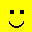

A simple smiley face with a yellow background, featuring two black dots for eyes and a curved line for a mouth, typically used to convey happiness or friendliness.


In [ ]:
image_base64 = (
    "iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAhElEQVR4nO2W4QqA"
    "MAiEVXr/VzYWDGoMdk7Cgrt/sUs/DqZTd3EplFU2JwATYAJMoOlAB4bq89s95+Mg"
    "+gyAchsKAYplBBBA43hFhfxnUixDjdEUUL8hpr7R0KLdt9qElzcyiu8As+Kr8zQA"
    "mgLavAl+kIzFZyCRxtsAmWb/voZvqRzgBE1sIDuVFX4eAAAAAElFTkSuQmCC"
)
image = Image.open(io.BytesIO(base64.b64decode(image_base64)))


@Template.define
def describe_image(image: Image.Image) -> str:
    """Return a short description of the following image.
    {image}
    """
    raise NotHandled


with handler(provider):
    display(
        HTML(
            f'<img src="data:image/png;base64,{image_base64}" alt="Example image" width="320" />'
        )
    )
    print(describe_image(image))

## Structured Output Generation

Constrained generation is used for any type that is convertible to a Pydantic model.

In [ ]:
@dataclasses.dataclass
class KnockKnockJoke:
    whos_there: str
    punchline: str


@Template.define
def write_joke(theme: str) -> KnockKnockJoke:
    """Write a knock-knock joke on the theme of {theme}. Do not use any tools."""
    raise NotHandled


@Template.define
def rate_joke(joke: KnockKnockJoke) -> bool:
    """Decide if {joke} is funny or not. Do not use any tools."""
    raise NotHandled


def do_comedy():
    joke = write_joke("lizards")
    print("> You are onstage at a comedy club. You tell the following joke:")
    print(
        f"Knock knock.\nWho's there?\n{joke.whos_there}.\n{joke.whos_there} who?\n{joke.punchline}"
    )
    if rate_joke(joke):
        print("> The crowd laughs politely.")
    else:
        print("> The crowd stares in stony silence.")


with handler(provider):
    do_comedy()

> You are onstage at a comedy club. You tell the following joke:
Knock knock.
Who's there?
Lizard.
Lizard who?
Lizard who? Lizard you wonder, there's a gecko at your door!
> The crowd laughs politely.


## Template Composition

Templates defined in the lexical scope are also captured, enabling template composition. One template can use the result of another template in a pipeline:


In [ ]:
# Sub-templates for different story styles
@Template.define
def story_with_moral(topic: str) -> str:
    """Write a short story about {topic} and end with a moral lesson. Do not use any tools."""
    raise NotHandled


@Template.define
def story_funny(topic: str) -> str:
    """Write a funny, humorous story about {topic}. Do not use any tools."""
    raise NotHandled


# Main orchestrator template - has access to sub-templates
@Template.define
def write_story(topic: str, style: str) -> str:
    """Write a story about {topic} in the style: {style}.
    Available styles: 'moral' for a story with a lesson, 'funny' for humor. Use story_funny for humor, story_with_moral for a story with a lesson."""
    raise NotHandled


# Verify sub-templates are captured in write_story's lexical context
assert story_with_moral in write_story.tools.values()
assert story_funny in write_story.tools.values()
print("Sub-templates available to write_story:", write_story.tools.keys())

with handler(provider):
    print("=== Story with moral ===")
    print(write_story("a curious cat", "moral"))
    print()
    print("=== Funny story ===")
    print(write_story("a curious cat", "funny"))

Sub-templates available to write_story: dict_keys(['describe_image', 'draw_simple_icon', 'limerick', 'haiku_no_cache', 'primes', 'count_char', 'cities', 'weather', 'vacation', 'write_joke', 'rate_joke', 'story_with_moral', 'story_funny'])
=== Story with moral ===


In the case of Whiskers, it was his understanding of this balance that brought him safely home, with both stories and lessons to cherish and share.

=== Funny story ===


The End.


## Retrying LLM Requests
LLM calls can sometimes fail due to transient errors or produce invalid outputs. The `RetryLLMHandler` automatically retries failed template calls and can also surface tool/runtime errors as tool messages:

- `num_retries`: Maximum number of retry attempts (default: 3)
- `include_traceback`: When `True`, include traceback details in the error feedback (default: False)
- `catch_tool_errors`: Exception type(s) to catch during tool execution (default: `Exception`)


Example usage: having an unstable service that seldomly fail.

In [ ]:
call_count = 0
REQUIRED_RETRIES = 3


@Tool.define
def unstable_service() -> str:
    """Fetch data from an unstable external service. May require retries."""
    global call_count
    call_count += 1
    if call_count < REQUIRED_RETRIES:
        raise ConnectionError(
            f"Service unavailable! Attempt {call_count}/{REQUIRED_RETRIES}. Please retry."
        )
    return "{ 'status': 'ok', 'data': [1, 2, 3] }"


@Template.define  # unstable_service auto-captured from lexical scope
def fetch_data() -> str:
    """Use the unstable_service tool to fetch data."""
    raise NotHandled


with handler(provider):
    try:
        result = fetch_data()
    except Exception as e:
        print(f"Error: {e}")

with handler(provider), handler(RetryLLMHandler(num_retries=3)):
    result = fetch_data()
    print(f"Result: {result}", "Retries:", call_count)

Error: Service unavailable! Attempt 1/3. Please retry.
Result: The data fetched from the unstable service is: `[1, 2, 3]`. Retries: 3


## Retrying with Validation Errors
As noted above, the `RetryHandler` can also be used to retry on runtime/validation error:

In [ ]:
@pydantic.dataclasses.dataclass
class Rating:
    score: int
    explanation: str

    @field_validator("score")
    @classmethod
    def check_score(cls, v):
        if v < 1 or v > 5:
            raise PydanticCustomError(
                "invalid_score",
                "score must be 1–5, got {v}",
                {"v": v},
            )
        return v

    @field_validator("explanation")
    @classmethod
    def check_explanation_contains_score(cls, v, info):
        score = info.data.get("score", None)
        if score is not None and str(score) not in v:
            raise PydanticCustomError(
                "invalid_explanation",
                "explanation must mention the score {score}, got '{explanation}'",
                {"score": score, "explanation": v},
            )
        return v


@Template.define
def give_rating_for_movie(movie_name: str) -> Rating:
    """Give a rating for {movie_name}. The explanation MUST include the numeric score. Do not use any tools."""
    raise NotHandled


with handler(provider):
    try:
        rating = give_rating_for_movie("Die Hard")
    except Exception as e:
        print(f"Error: {e}")

with handler(provider), handler(RetryLLMHandler(num_retries=3)):
    rating = give_rating_for_movie("Die Hard")
    print(f"Score: {rating.score}/5")
    print(f"Explanation: {rating.explanation}")

Error: Error decoding response: 1 validation error for Response
value.score
  score must be 1–5, got 9 [type=invalid_score, input_value=9, input_type=int]. Please provide a valid response and try again.
Score: 5/5
Explanation: Die Hard is widely acclaimed as one of the best action films of all time and earns a perfect score of 5 out of 5. Its success is attributed to a gripping storyline, memorable performances, particularly by Bruce Willis as John McClane, and its innovative approach to action sequences. Its mix of humor, suspense, and holiday-themed backdrop makes it a perennial favorite, cementing its status as a cultural icon.


## Generating higher-order functions
Finally, we can generate higher-order functions that can call templates as well:

In [ ]:
# Sub-templates for different story styles
@Template.define
def write_chapter(chapter_number: int, chapter_name: str) -> str:
    """Write a short story about {chapter_number}. Do not use any tools."""
    raise NotHandled


@Template.define
def judge_chapter(story_so_far: str, chapter_number: int) -> bool:
    """Decide if the new chapter is coherence with the story so far. Do not use any tools."""
    raise NotHandled


# Main orchestrator template - has access to sub-templates
@Template.define
def write_multi_chapter_story(style: Literal["moral", "funny"]) -> Callable[[str], str]:
    """Generate a function that writes a story in style: {style} about the given topic.

    The program can use helper functions defined elsewhere (DO NOT REDEFINE THEM):
    - write_chapter(chapter_number: int, chapter_name: str) -> str
    - judge_chapter(story_so_far: str, chapter_number: int) -> bool"""
    raise NotHandled


# Verify sub-templates are captured in write_story's lexical context
print("Sub-templates available to write_story:", write_multi_chapter_story.tools.keys())

with (
    handler(RetryLLMHandler(num_retries=3)),
    handler(provider),
    handler(UnsafeEvalProvider()),
):
    print("=== Story with moral ===")
    function_that_writes_story = write_multi_chapter_story("moral")
    print(inspect.getsource(function_that_writes_story))
    print(function_that_writes_story("a curious cat"))
    print()

Sub-templates available to write_story: dict_keys(['describe_image', 'draw_simple_icon', 'limerick', 'haiku_no_cache', 'primes', 'count_char', 'cities', 'weather', 'vacation', 'write_joke', 'rate_joke', 'story_with_moral', 'story_funny', 'write_story', 'unstable_service', 'fetch_data', 'give_rating_for_movie', 'write_chapter', 'judge_chapter'])
=== Story with moral ===
def create_moral_story(topic: str) -> str:
    # Start with an introduction and establish the story theme
    chapter_1 = write_chapter(1, f"Introduction to {topic}")
    
    # Develop the plot with a challenge or situation related to the topic
    chapter_2 = write_chapter(2, f"The Challenge of {topic}")
    
    # Introduce a turning point or decision-making moment involving the topic
    chapter_3 = write_chapter(3, f"Decisions and Consequences of {topic}")
    
    # Conclusion wrapping up the story and highlighting the moral
    chapter_4 = write_chapter(4, f"Moral and Lessons of {topic}")
    
    # Combine all ch